## Previsão Ibovespa
Esse notebook tem como objetivo realizar a previsão do índice IBovespa utilizando alguns modelos de Machine Learning. Esse projeto foi realizado como parte da Fase 2 da pós graduação em Data Analytics da POSTECH FIAP.

### 1. Entendimento do Negócio
O problema
Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para criar uma série temporal e prever diariamente o fechamento da base.

Você precisará demonstrar para o time de investimentos:
1. O modelo com o storytelling, desde a captura do dado até a entrega do
modelo;
2. Justificar a técnica utilizada;
3. Atingir uma acuracidade adequada (acima de 70%)

### 2. Entendimento dos Dados
Para isso, utilize a base de dados contida no site da Investing https://br.investing.com/indices/bovespa-historical-data) e selecione o período “diário”, com o intervalo de tempo que achar adequado.

Testaremos alguns períodos Históricos para treinamento com uso de 180 dias anteriores para previsão.

In [ ]:
!pip install requests beautifulsoup4 pandas

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [3]:
# web scraping
url = "https://br.investing.com/indices/bovespa-historical-data"
response = requests.get(url)

In [4]:
soup = BeautifulSoup(response.content, 'html.parser')

In [5]:
# Nome da Tabela
table = soup.find('table', {'class': 'freeze-column-w-1 w-full overflow-x-auto text-xs leading-4'})


In [10]:
# Ver a linha correta do código para puxar os dados

# Criar listas para armazenar os dados
#dates, ultimo, abertura, maxima, minima, vol, var_per= [], [], [], [], [], [], []
dates, ultimo = [], []

# Iterar sobre as linhas da tabela
for row in table.find_all('th'):
    cols = row.find_all('tr')
    if len(cols) > 0:
        date = cols[0].text.strip()
        ultimo = cols[1].text.strip()
        #dates.append(date)
        #prices.append(price)

# Criar um DataFrame
#df = pd.DataFrame({'Data': dates, 'Ultimo': ultimo,'Maxima': maxima, 'Minima': minima, 'Vol.': vol, 'Var%': var_per})
df= pd.DataFrame({'Data': dates, 'Ultimo': ultimo})

In [11]:
df.head()

,Data,Ultimo


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import datetime


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [ ]:
url = 'https://raw.githubusercontent.com/Data-Analitycs-Pos-Tech-Fiap/Ibovespa-prev/refs/heads/main/datasets/Dados%20Hist%C3%B3ricos%20-%20Ibovespa%202000%20a%202025.csv'

dados = pd.read_csv(url, sep=',', encoding='utf-8')

dados.head(3)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,03.01.2025,118.533,120.125,120.356,118.404,"9,80B","-1,33%"
1,02.01.2025,120.125,120.283,120.782,119.120,"9,37B","-0,13%"
2,30.12.2024,120.283,120.267,121.050,120.158,"8,90B","0,01%"


In [ ]:
# compreendendo os tipos de dados e o shape da base
print(dados.info())
print('----------------------------------------------------')
print('TAMANHO DA BASE: ', dados.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      4954 non-null   object 
 1   Último    4954 non-null   float64
 2   Abertura  4954 non-null   float64
 3   Máxima    4954 non-null   float64
 4   Mínima    4954 non-null   float64
 5   Vol.      4953 non-null   object 
 6   Var%      4954 non-null   object 
dtypes: float64(4), object(3)
memory usage: 271.0+ KB
None
----------------------------------------------------
TAMANHO DA BASE:  (4954, 7)


In [ ]:
dados.columns

Index(['Data', 'Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], dtype='object')

In [ ]:

# Ordenar o índice em ordem crescente
dados = dados.sort_index()
dados = dados.set_index('Data')


In [ ]:
# Convertendo a coluna 'Data' para datetime
dados.index = pd.to_datetime(dados.index, format='%d.%m.%Y')

# Ordenar o índice em ordem crescente
dados = dados.sort_index()

dados = dados.asfreq('D', method='pad')
dados.reset_index(inplace=True)

# preenchendo o restante das colunas com o último valor válido
for column in dados.columns:
    dados[column].fillna(dados[column].iloc[-1], inplace=True)

# verificando o resultado
dados.head(10)


C:\Users\kelvyn.candido\AppData\Local\Temp\ipykernel_21032\1707999174.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados[column].fillna(dados[column].iloc[-1], inplace=True)


,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2024-07-04,126.164,125.666,126.660,125.666,"6,54M","0,40%"
1,2024-07-05,126.267,126.165,126.662,125.556,"8,09M","0,08%"
2,2024-07-06,126.267,126.165,126.662,125.556,"8,09M","0,08%"
3,2024-07-07,126.267,126.165,126.662,125.556,"8,09M","0,08%"
4,2024-07-08,126.548,126.280,126.551,125.614,"7,43M","0,22%"
5,2024-07-09,127.108,126.548,127.295,125.937,"6,68M","0,44%"
6,2024-07-10,127.218,127.109,127.769,126.928,"8,15M","0,09%"
7,2024-07-11,128.294,127.221,128.326,127.221,"7,97M","0,85%"
8,2024-07-12,128.897,128.293,129.015,128.002,"7,21M","0,47%"
9,2024-07-13,128.897,128.293,129.015,128.002,"7,21M","0,47%"


In [ ]:
# incluindo coluna categórica
dados['unique_id'] = 'ibovespa'

In [ ]:
# renomeando colunas
dados = dados.rename(columns={'Data': 'ds', 'Último': 'y'})
# selecionando colunas
dados = dados[['ds', 'y', 'unique_id']]
dados.head(10)

,ds,y,unique_id
0,2024-07-04,126.164,ibovespa
1,2024-07-05,126.267,ibovespa
2,2024-07-06,126.267,ibovespa
3,2024-07-07,126.267,ibovespa
4,2024-07-08,126.548,ibovespa
5,2024-07-09,127.108,ibovespa
6,2024-07-10,127.218,ibovespa
7,2024-07-11,128.294,ibovespa
8,2024-07-12,128.897,ibovespa
9,2024-07-13,128.897,ibovespa


In [ ]:
# df com data como índice e valores só coluna y
df1 = dados[['ds', 'y']]
df1 = dados.set_index('ds')

In [ ]:
dados.head(1)

,ds,y,unique_id
0,2024-07-04,126.164,ibovespa


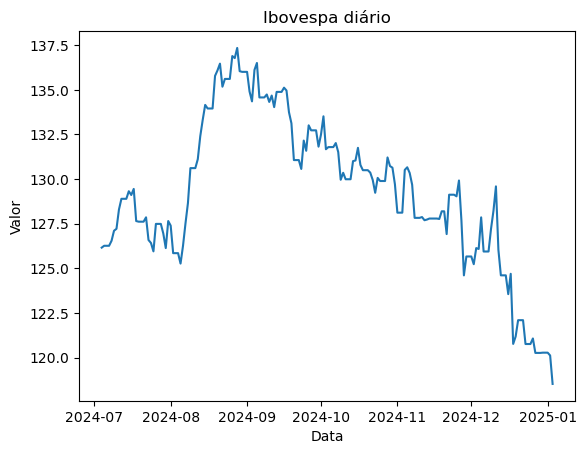

In [ ]:
plt.plot(df1.index, df1["y"])
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Ibovespa diário')
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
resultados = seasonal_decompose(df1['y'], model='additive', period=1)


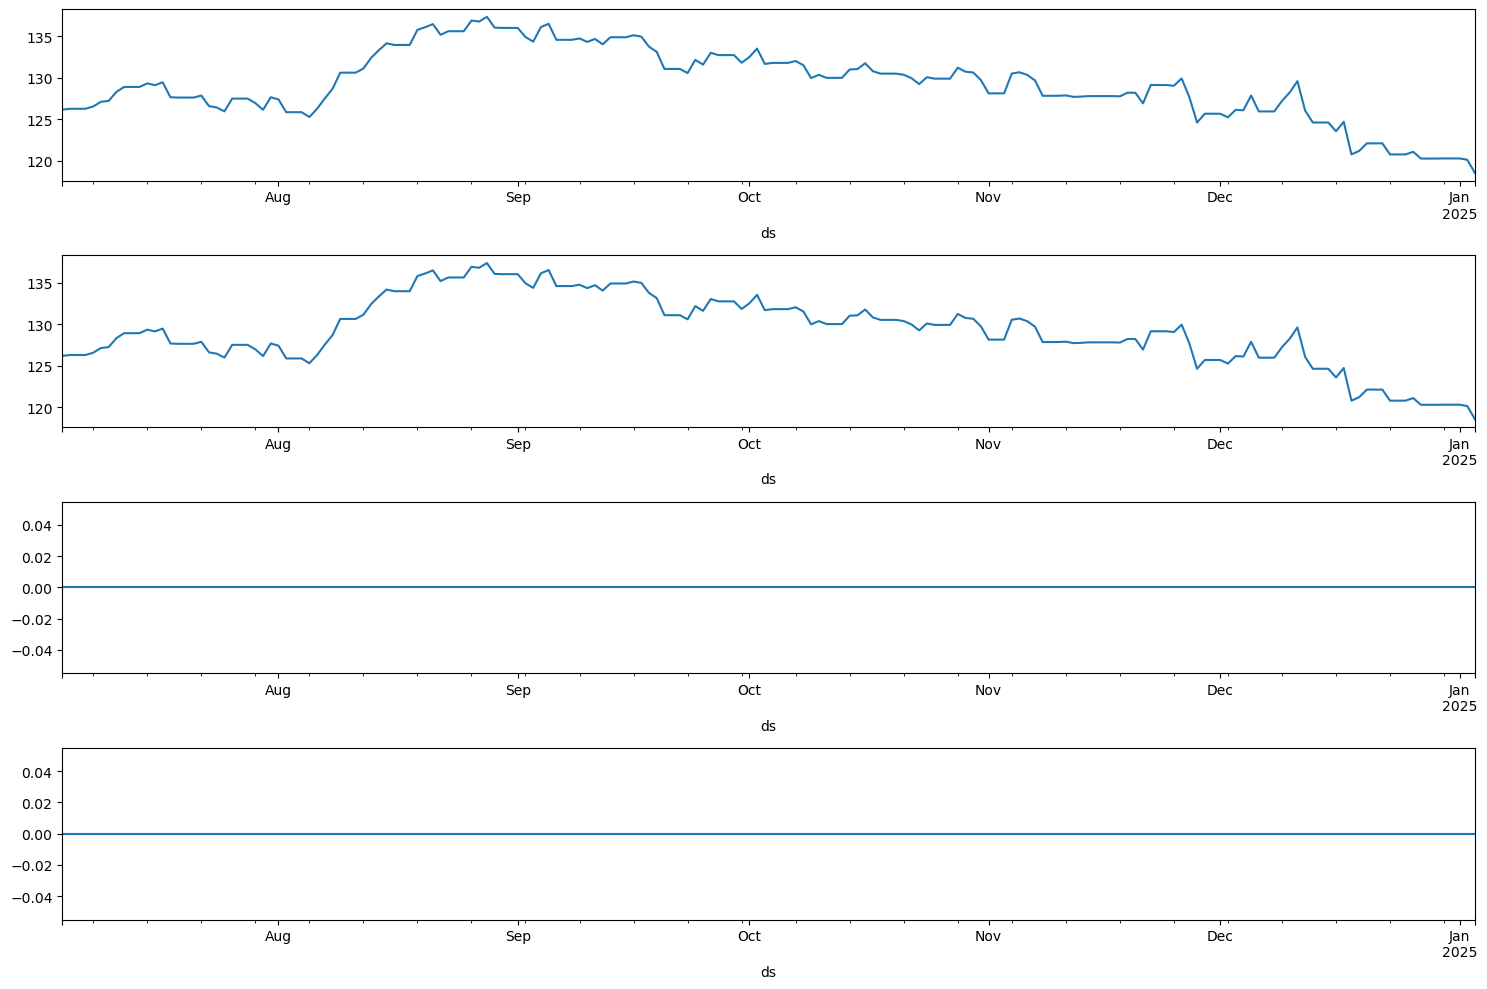

In [ ]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

# mostrando a série do data frame
resultados.observed.plot(ax=ax1)
# mostrando a tendência dos dados
resultados.trend.plot(ax=ax2)
# mostrando a sazonalidade - constante e recorrente
resultados.seasonal.plot(ax=ax3)
# mostrando os resíduos
resultados.resid.plot(ax=ax4)

plt.tight_layout()

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
X = df1.y.values

In [ ]:
result = adfuller(X)

# como o teste estatístico é maior que os valores críticos e temos um p-value alto, descartamos a hipótese de série estacionária

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -0.5046569735253487
P-Value: 0.8911045109775122
Valores críticos:
	1%: -3.466598080268425
	5%: -2.8774669520682674
	10%: -2.5752604356654425


In [ ]:
df1.shape

(184, 2)

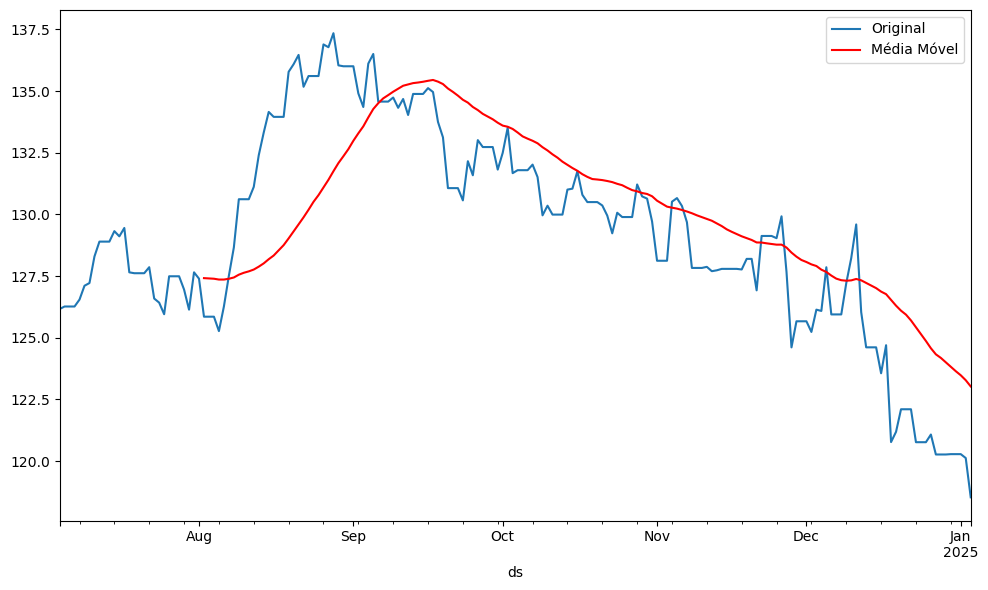

In [ ]:
# Calcular média móvel com janela menor
ma = df1['y'].rolling(window=30).mean()

# Criar o gráfico
f, ax = plt.subplots(figsize=(10,6))
df1['y'].plot(ax=ax, label='Original')
ma.plot(ax=ax, color='r', label='Média Móvel')
plt.legend()
plt.tight_layout()




In [ ]:
# Verificar o DataFrame df1
print("Informações do DataFrame:")
print(df1.info())
print("\nPrimeiras linhas do DataFrame:")
print(df1.head())

# Verificar a série da média móvel
print("\nInformações da média móvel:")
print(ma.head())
print("\nVerificar valores nulos na média móvel:")
print(ma.isnull().sum())


Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184 entries, 2024-07-04 to 2025-01-03
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   y          184 non-null    float64
 1   unique_id  184 non-null    object 
dtypes: float64(1), object(1)
memory usage: 4.3+ KB
None

Primeiras linhas do DataFrame:
                  y unique_id
ds                           
2024-07-04  126.164  ibovespa
2024-07-05  126.267  ibovespa
2024-07-06  126.267  ibovespa
2024-07-07  126.267  ibovespa
2024-07-08  126.548  ibovespa

Informações da média móvel:
ds
2024-07-04   NaN
2024-07-05   NaN
2024-07-06   NaN
2024-07-07   NaN
2024-07-08   NaN
Name: y, dtype: float64

Verificar valores nulos na média móvel:
29
